# Modeling

## Overview

From the initial EDA, we learned of a few interesting relationships:
<br>
<br>1. Negative linear relationship between temperature and gas usage
<br>2. (Somewhat) Linear relationship between gas usage, temperature, and PM10 particulate occurance
<br>3. Cyclic behaviour in generation of gas, electricity, and PM10 particulate occurance
<br><br>
We will explore these relationships in hopes of creating accurate models to predict behaviours in related data points.

## Temperature and Gas Usage: Linear Regression

The first relationship we will explore is between temperature and gas usage. In the initial EDA, we saw quite a linear relationship, so we will focus on *linear regression* to predict gas usage based on the temperatures across the different provinces.

### Import extensions and data

In [1]:
# Extensions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from datetime import date
%matplotlib inline

In [66]:
# Modeling 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold

from sklearn import metrics
from sklearn.metrics import classification_report, precision_score, recall_score

In [6]:
# Electricity and Gas
df = pd.read_excel('Data/Korea_Electricity_and_Gas.xlsx')

# Gas
locs = list(range(0,3)) + list(range(19,35))
gas = df.iloc[:,locs]
gas

,Year,Month,Temperature,Gangwondo_Gas,Gyeonggido_Gas,Gyeongsangnamdo_Gas,Gyeongsangbukdo_Gas,Jeollanamdo_Gas,Jeollabukdo_Gas,Jeju_Gas,Chungcheongnamdo_Gas,Chungcheongbukdo_Gas,Seoul_Gas,Incheon_Gas,Gwangju_Gas,Daegu_Gas,Daejeon_Gas,Busan_Gas,Ulsan_Gas
0,2000,1,-1.20,16219,363014,42129,55362,22508,34507,0,20158,27838,662424,139454,39465,86077,52992,85787,69241
1,2000,2,-0.99,16280,375937,42604,52863,22310,33784,0,23492,27175,689177,145834,40674,84069,53950,87282,70910
2,2000,3,6.64,14105,323145,35990,47282,18033,29315,0,21156,22904,566528,121324,34610,76144,41898,74476,63627
3,2000,4,12.11,10364,237437,28698,40393,15920,19783,0,17447,16818,396231,91421,25898,62514,28618,58316,47106
4,2000,5,17.59,6843,169495,21073,35083,13808,14375,0,14508,12299,262940,67239,18426,46992,17503,45915,43749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,2020,8,27.00,19076,255222,60523,84646,49039,43885,1506,70181,49460,163032,70646,27561,45058,31906,70508,94251
248,2020,9,21.40,18822,243817,65264,88652,54253,48190,1179,86971,53589,147556,72542,28120,43042,30307,70849,101433
249,2020,10,14.90,25946,339823,75071,103757,60416,61328,1414,109095,61315,213556,78654,39428,44555,42001,85283,119332
250,2020,11,9.00,35632,497221,101609,135432,68793,82360,2161,142556,82499,375289,115663,58120,67054,69624,122943,147792


In [8]:
gas['DATE'] = pd.to_datetime(gas[['Year', 'Month']].assign(DAY=1))
gas.DATE

0     2000-01-01
1     2000-02-01
2     2000-03-01
3     2000-04-01
4     2000-05-01
         ...    
247   2020-08-01
248   2020-09-01
249   2020-10-01
250   2020-11-01
251   2020-12-01
Name: DATE, Length: 252, dtype: datetime64[ns]

In [61]:
# Weather (Temperature)
weather = pd.read_excel('Data/Korea Average Temperature by Region.xlsx')
weather

,Year,Month,Overall,Gangwondo,Gyeonggido,Gyeongsamnamdo,Gyeongsambukdo,Jeollanamdo,Jeollabukdo,Jeju,Chungcheongnamdo,Chungcheongbukdo,Seoul,Incheon,Gwangju,Daegu,Daejeon,Busan,Ulsan
0,2000,1,-1.20,-3.0,-2.1,3.3,2.7,1.0,0.8,6,-,-1.2,-2.1,-1.5,1.0,1.1,-1.2,4.2,3.1
1,2000,2,-0.99,-3.2,-1.7,3.0,2.3,0.6,0.2,4.6,-,-1.6,-1.7,-1.2,0.6,1.3,-1.1,3.2,2.7
2,2000,3,6.64,4.9,6.3,8.9,8.9,6.9,6.9,9.4,-,5.7,6.3,6.0,6.9,7.9,6.1,9.1,8.7
3,2000,4,12.11,10.8,11.9,13.4,13.9,12.6,12.8,13.5,-,11.5,11.9,11.5,12.6,13.0,11.9,13.2,13.6
4,2000,5,17.59,16.7,17.5,17.9,18.7,17.8,18.2,17.2,-,17.2,17.5,16.5,17.8,19.5,17.2,17.3,18.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,2020,8,27.00,26.1,26.5,27.5,28.6,27.6,27.7,29.4,26.8,27.7,26.5,25.9,27.6,28.6,27.5,27.2,27.6
248,2020,9,21.40,19.7,21.4,21.5,21.6,21.3,21.3,22.9,20.7,21.5,21.4,21.3,21.3,21.2,21.2,21.9,21.1
249,2020,10,14.90,11.9,14.3,16.0,16.4,15.7,14.9,18.4,13.2,14.5,14.3,14.8,15.7,15.4,14.2,17.3,15.9
250,2020,11,9.00,6.1,8.0,10.7,11.3,10.5,9.6,14.1,8.1,8.8,8.0,8.3,10.5,9.7,8.6,12.4,11.0


Note that there are missing values in the 'Chungcheongnamdo' column of the temperature data. However, the two dataframes are the same size 252 rows x 19 columns (with an additional DATE row added to the gas dataframe).

### Dealing with missing values

In the gas dataset, the 'Jeju' column has many 0 values, which aren't necessarily expected, but could just be a replacement for unknown values. We will leave it for now.

In [10]:
gas.isnull().sum()

Year                    0
Month                   0
Temperature             0
Gangwondo_Gas           0
Gyeonggido_Gas          0
Gyeongsangnamdo_Gas     0
Gyeongsangbukdo_Gas     0
Jeollanamdo_Gas         0
Jeollabukdo_Gas         0
Jeju_Gas                0
Chungcheongnamdo_Gas    0
Chungcheongbukdo_Gas    0
Seoul_Gas               0
Incheon_Gas             0
Gwangju_Gas             0
Daegu_Gas               0
Daejeon_Gas             0
Busan_Gas               0
Ulsan_Gas               0
DATE                    0
dtype: int64

On the other hand, the weather dataframe has several '-' values, used to represent unknown data as well! Let's see the scale of unknown values.

In [62]:
(weather == '-').sum()

Year                  0
Month                 0
Overall               0
Gangwondo             0
Gyeonggido            0
Gyeongsamnamdo        0
Gyeongsambukdo        0
Jeollanamdo           0
Jeollabukdo           0
Jeju                  2
Chungcheongnamdo    204
Chungcheongbukdo      0
Seoul                 0
Incheon               0
Gwangju               0
Daegu                 0
Daejeon               0
Busan                 0
Ulsan                 0
dtype: int64

Here, we can see that there are 204 unknown values in the 'Chungcheongnamdo' column (out of 252 rows). There is <b>too much missing data here</b>, so for now we will just <b>remove the province</b> from our considerations. There are also 2 unknown values for 'Jeju', but since they are so few, we can just use an *average temperature to replace these values*.

In [63]:
# Remove the Chungcheongnamdo column from both dataframes
weather = weather.drop(columns='Chungcheongnamdo')
gas = gas.drop(columns='Chungcheongnamdo_Gas')

In [64]:
weather[weather.Jeju == '-']

,Year,Month,Overall,Gangwondo,Gyeonggido,Gyeongsamnamdo,Gyeongsambukdo,Jeollanamdo,Jeollabukdo,Jeju,Chungcheongbukdo,Seoul,Incheon,Gwangju,Daegu,Daejeon,Busan,Ulsan
204,2017,1,-0.35,-3.0,-1.8,2.6,2.9,2.0,0.8,-,-0.8,-1.8,-0.9,2.0,1.1,-0.4,4.1,2.8
213,2017,10,16.57,13.9,16.4,17.5,17.5,17.0,16.0,-,15.9,16.4,15.7,17.0,16.2,15.4,18.1,17.0


We can see here that the two missing values in 'Jeju' are from January and October of 2017. We'll replace these values with the average temperature in Jeju for these months.

In [38]:
# Create replacement value for January and October
january = weather[weather.Month == 1]
jeju_january = january['Jeju'].drop(index=204)
jeju_january_replace = jeju_january.mean()

october = weather[weather.Month == 10]
jeju_october = october['Jeju'].drop(index=213)
jeju_october_replace = jeju_october.mean().round(2)

print(jeju_january_replace, jeju_october_replace)

6.03 18.72


In [65]:
# Replace:
weather.loc[204,'Jeju']=jeju_january_replace
weather.loc[213,'Jeju']=jeju_october_replace
(weather == '-').sum()

Year                0
Month               0
Overall             0
Gangwondo           0
Gyeonggido          0
Gyeongsamnamdo      0
Gyeongsambukdo      0
Jeollanamdo         0
Jeollabukdo         0
Jeju                0
Chungcheongbukdo    0
Seoul               0
Incheon             0
Gwangju             0
Daegu               0
Daejeon             0
Busan               0
Ulsan               0
dtype: int64

### Split data to test and training sets
Split data into training and testing data, with an 80/20 split. Since we have multiple provinces and cities, we can separately train models for each. However, let's first try to train a model using only the 'Gyeonggido' province data.

In [104]:
X_train, X_test, y_train, y_test = train_test_split(weather.Gyeonggido, gas.Gyeonggido_Gas, test_size=0.2)

In [105]:
print(X_train.shape, y_train.shape)
X_train.head()

(201,) (201,)


146     5.1
121     1.4
45     13.9
142    10.7
23     -0.6
Name: Gyeonggido, dtype: float64

### Deploying and evaluating Ordinary Least Squares Linear Regression Model

In [108]:
linReg = LinearRegression()
linReg.fit(X_train.array.reshape(-1,1), y_train)

LinearRegression()

In [142]:
y_pred = linReg.predict(X_test.array.reshape(-1,1))
print(linReg.intercept_, linReg.coef_)

567738.4350133716 [-16100.66106996]


In [154]:
rss = np.sum((y_test - y_pred)**2)
ess = np.sum((y_pred - np.mean(y_test))**2)
r2 = (ess/(ess + rss)).round(3)
print('R-Squared value for the model: ', r2)

R-Squared value for the model:  0.733


In [157]:
fstat = ((r2/(1-r2))*250).round(1)
print('F-stat value for the model: ', fstat)

F-stat value for the model:  686.3


In [159]:
print("RMS Error: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

RMS Error:  95865.18403732362


In [143]:
import statsmodels.formula.api as smf

In [146]:
smlin = smf.ols(formula='Temperature ~ Gyeonggido_Gas', data=gas).fit()
smlin.params
print(smlin.summary())

                            OLS Regression Results                            
Dep. Variable:            Temperature   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     847.9
Date:                Sun, 11 Jun 2023   Prob (F-statistic):           2.71e-82
Time:                        21:15:15   Log-Likelihood:                -739.05
No. Observations:                 252   AIC:                             1482.
Df Residuals:                     250   BIC:                             1489.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         29.6389      0.628     47.

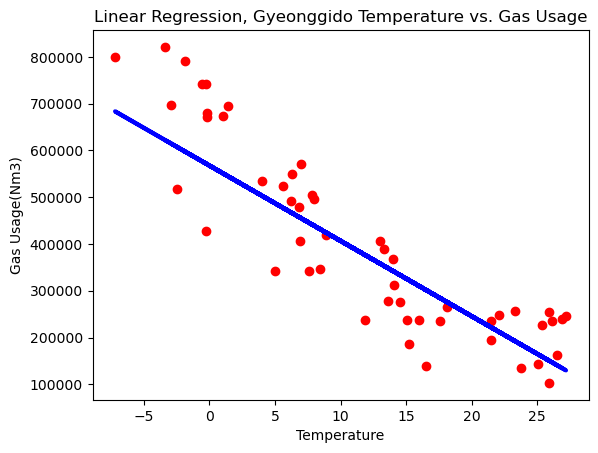

In [164]:
plt.scatter(X_test, y_test, color='r')
plt.plot(X_test, y_pred, color='b', linewidth=3)
plt.xlabel('Temperature')
plt.ylabel('Gas Usage(Nm3)')
plt.title('Linear Regression, Gyeonggido Temperature vs. Gas Usage');

### Gradient Descent Linear Regression Model

In [166]:
from sklearn import linear_model
linReg2 = linear_model.SGDRegressor(max_iter=1000, tol=1e-5, random_state=0)
linReg2.fit(X_train.array.reshape(-1,1), y_train)

SGDRegressor(random_state=0, tol=1e-05)

In [168]:
y_pred2 = linReg2.predict(X_test.array.reshape(-1,1))
print(linReg2.intercept_, linReg2.coef_)

[559482.49626407] [-17049.76058756]


In [169]:
rss = np.sum((y_test - y_pred2)**2)
ess = np.sum((y_pred2 - np.mean(y_test))**2)
r2 = (ess/(ess + rss)).round(3)
print('R-Squared value for the model: ', r2)

R-Squared value for the model:  0.746


In [170]:
fstat = ((r2/(1-r2))*250).round(1)
print('F-stat value for the model: ', fstat)

F-stat value for the model:  734.3


In [171]:
print("RMS Error: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred2)))

RMS Error:  99862.2125674635


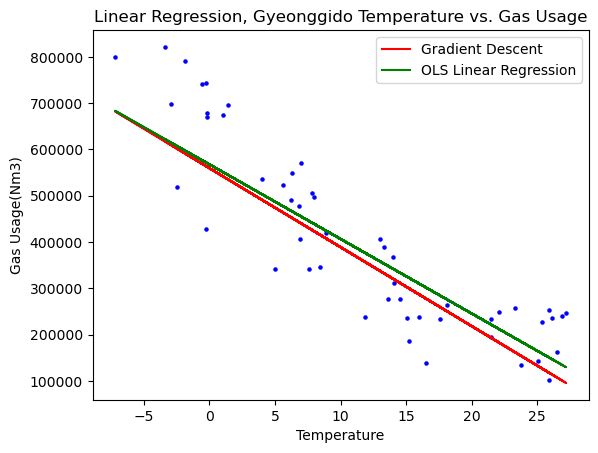

In [183]:
plt.scatter(X_test, y_test, color='b', s=5)
plt.plot(X_test, y_pred2, color='red', label='Gradient Descent')
plt.plot(X_test, y_pred, color='green', label='OLS Linear Regression')
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Gas Usage(Nm3)')
plt.title('Linear Regression, Gyeonggido Temperature vs. Gas Usage');